In [3]:
cd ../..

/disk1/home/svo6059/masters/spikelearn


# Environment

## Imports

In [4]:
import sys
sys.path.append('.')
import os
from spikelearn import frankenstein, shuffle_val_predict
from spikelearn.models import shuffle_cross_predict
from spikelearn.data import io, SHORTCUTS, select, to_feature_array
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, cross_val_predict, GroupKFold
import numpy as np

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from itertools import product
from spikelearn.models.shuffle_decoding import MonteCarloFeatures

## Functions 

In [1]:
def label_last_times(df, timewindow=200, offset=0, bootstrap=False):
    assert df['time'].nunique() == df['time'].shape[0]
    df = df[df.time>200]
    if bootstrap:
        target_time = df['time'][df['time']>-timewindow].sample().values[0]
    else:
        target_time = df['time'].max() - offset
    df['label'] = ((df['time'] >= (target_time - timewindow)) &
                   (df['time'] <=  target_time) )
    return df

In [2]:
def to_response_df(df, btime=200, Xyt=False, offset=0, bootstrap=False):
    """
    Returns a dataframe of features as columns, 
    with examples labeled as 1 if they are between _btime_ ms of the exiting time
    """
    subset= ['full', 'full_times']
    df = df.copy()[subset]

    rates = pd.DataFrame(df[subset[0]].tolist(),
                index=df.index).reset_index().melt(['trial','unit'])
    times = pd.DataFrame(df[subset[1]].tolist(),
                index=df.index).reset_index().melt(['trial','unit'])

    rates['time'] = times.value
    rates = rates.drop('variable',axis=1).dropna()
    rates = rates.set_index(['unit','trial','time']).unstack(0).reset_index()
    rates = rates.groupby('trial').apply(label_last_times, offset=offset, bootstrap=bootstrap, timewindow=btime)\
                                  .set_index(['trial','label', 'time'])
    rates.columns = rates.columns.droplevel()
    if Xyt:
        X = rates.values
        rates = rates.reset_index()
        y = rates['label'].values
        trial = rates['trial'].values
        time = rates['time'].values
        return X, y, trial, time
    else:
        return rates

In [39]:
def onset_rmse(rat, offset, boot=False, strpfc=None, return_n_features=False):
    if strpfc is None:
        rat = select(io.load(rat, 'wide_smoothed'), _min_duration=2, is_selected=True, is_tired=False)
        pipe = make_pipeline(RobustScaler(),
                         RandomUnderSampler(),
                         LogisticRegression(solver='lbfgs'))
    else:
        n_neurons = select(io.load(rat, 'wide_smoothed'), _min_quality=0).reset_index().drop_duplicates('unit').area.value_counts().min()
        rat = select(io.load(rat, 'wide_smoothed'), _min_duration=1.5, _min_quality=0, area=strpfc)
        
        pipe = make_pipeline(RobustScaler(),
                         RandomUnderSampler(),
                         MonteCarloFeatures(n_neurons),
                         LogisticRegression(solver='lbfgs'))
        
    X, y, t, time = to_response_df(rat, 200, True, offset, boot)
    
    if X.shape[0]==0:
        return np.nan
    res = cross_val_predict(pipe, X, y, t, cv=10)
    res = pd.DataFrame(np.stack((t, y, res, time)).T)
    res.columns=['trial', 'true', 'pred', 'time']
    
    mean_predicted_onset = res[res.pred.astype(bool)].groupby('trial')['time'].mean()
    mean_true_onset = res[res.true.astype(bool)].groupby('trial')['time'].mean()
    rmse = np.sqrt((mean_true_onset - mean_predicted_onset).dropna()**2).mean()
    
    if return_n_features:
        return rmse, X.shape[1]
    else:
        return rmse

### Visualization 

# Exploratory Analysis  

## PFC 

In [40]:
[onset_rmse('DRRD 8', i*100) for i in range(15)]

KeyboardInterrupt: 

In [ ]:
[onset_rmse('DRRD 8', i*100, True) for i in range(15)]

In [89]:
[onset_rmse('DRRD 9', i*100) for i in range(15)]

[903.7477761961121,
 699.8050120927551,
 698.7208210032842,
 683.7892937320285,
 636.286901100864,
 596.4368967148304,
 570.2144652407762,
 558.6993878816421,
 581.6085629285946,
 558.1560832250426,
 533.5668328275208,
 522.3200575892796,
 530.818981192199,
 573.9734975604587,
 612.0407041792429]

In [90]:
[onset_rmse('DRRD 10', i*100) for i in range(15)]

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[858.0344811650668,
 808.5965613781412,
 793.1243709425058,
 788.4457507117714,
 749.9918383944403,
 727.529892982829,
 679.3768493683696,
 616.2759695475185,
 553.323702807482,
 535.2283821575165,
 525.2387997229787,
 544.9422268222361,
 560.0220695867159,
 596.0979108742769,
 637.781055964171]

In [41]:
%%time
gabi_rats = {}
for i, rat in product(range(20), SHORTCUTS['groups']['DRRD']):
    %time gabi_rats[(rat, i)] = onset_rmse(rat, i*100)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 15 s, sys: 48.5 s, total: 1min 3s
Wall time: 6.01 s
CPU times: user 6.45 s, sys: 18.2 s, total: 24.7 s
Wall time: 2.89 s
CPU times: user 7.51 s, sys: 17.8 s, total: 25.3 s
Wall time: 4.19 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 23.2 s, sys: 1min 2s, total: 1min 25s
Wall time: 11.2 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 14.6 s, sys: 46.1 s, total: 1min
Wall time: 6 s
CPU times: user 7.58 s, sys: 21.7 s, total: 29.3 s
Wall time: 3.25 s
CPU times: user 6.76 s, sys: 13.7 s, total: 20.5 s
Wall time: 4.13 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 23.7 s, sys: 1min 4s, total: 1min 28s
Wall time: 11.5 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 12.6 s, sys: 37 s, total: 49.6 s
Wall time: 5.39 s
CPU times: user 6.17 s, sys: 18.4 s, total: 24.5 s
Wall time: 2.86 s
CPU times: user 6.67 s, sys: 14.8 s, total: 21.5 s
Wall time: 3.86 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 23.7 s, sys: 1min, total: 1min 24s
Wall time: 12.1 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 15.1 s, sys: 50.2 s, total: 1min 5s
Wall time: 5.81 s
CPU times: user 7.06 s, sys: 21.2 s, total: 28.3 s
Wall time: 3.24 s
CPU times: user 6.9 s, sys: 15.4 s, total: 22.3 s
Wall time: 4.03 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 23.5 s, sys: 1min 4s, total: 1min 28s
Wall time: 10.9 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 12.8 s, sys: 38 s, total: 50.8 s
Wall time: 5.56 s
CPU times: user 6.3 s, sys: 17.1 s, total: 23.4 s
Wall time: 3.04 s
CPU times: user 6.2 s, sys: 12.9 s, total: 19.1 s
Wall time: 3.68 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 21.9 s, sys: 55.9 s, total: 1min 17s
Wall time: 11.2 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 11.6 s, sys: 32.4 s, total: 44 s
Wall time: 5.29 s
CPU times: user 6.79 s, sys: 20.1 s, total: 26.9 s
Wall time: 3.03 s
CPU times: user 6.17 s, sys: 13.3 s, total: 19.4 s
Wall time: 3.59 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 22.1 s, sys: 55.9 s, total: 1min 17s
Wall time: 11.1 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 10.7 s, sys: 28.9 s, total: 39.6 s
Wall time: 5.09 s
CPU times: user 5.59 s, sys: 14.4 s, total: 20 s
Wall time: 2.84 s
CPU times: user 6.67 s, sys: 16.2 s, total: 22.9 s
Wall time: 3.83 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 21.8 s, sys: 57.6 s, total: 1min 19s
Wall time: 10.9 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 12 s, sys: 33 s, total: 45 s
Wall time: 5.32 s
CPU times: user 5.85 s, sys: 14.9 s, total: 20.8 s
Wall time: 2.91 s
CPU times: user 7.37 s, sys: 17.5 s, total: 24.8 s
Wall time: 4.03 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 22 s, sys: 58.5 s, total: 1min 20s
Wall time: 11.2 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 12.6 s, sys: 35.4 s, total: 48.1 s
Wall time: 5.68 s
CPU times: user 6.57 s, sys: 18 s, total: 24.6 s
Wall time: 3.07 s
CPU times: user 6.24 s, sys: 13.7 s, total: 19.9 s
Wall time: 3.78 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 21.9 s, sys: 58.9 s, total: 1min 20s
Wall time: 11.1 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 12.9 s, sys: 40 s, total: 52.9 s
Wall time: 5.7 s
CPU times: user 5.65 s, sys: 14.7 s, total: 20.4 s
Wall time: 2.84 s
CPU times: user 6.21 s, sys: 12.3 s, total: 18.5 s
Wall time: 3.74 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 22.4 s, sys: 57.9 s, total: 1min 20s
Wall time: 10.9 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 12.3 s, sys: 35.4 s, total: 47.7 s
Wall time: 5.36 s
CPU times: user 6.42 s, sys: 18.4 s, total: 24.8 s
Wall time: 3.03 s
CPU times: user 6.8 s, sys: 16.5 s, total: 23.3 s
Wall time: 3.89 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 22.1 s, sys: 58.7 s, total: 1min 20s
Wall time: 11.1 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 13.1 s, sys: 40.8 s, total: 53.9 s
Wall time: 5.57 s
CPU times: user 5.35 s, sys: 13.2 s, total: 18.6 s
Wall time: 2.72 s
CPU times: user 6.37 s, sys: 12.5 s, total: 18.8 s
Wall time: 4.03 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 21.3 s, sys: 55.4 s, total: 1min 16s
Wall time: 10.9 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 10.8 s, sys: 29.3 s, total: 40 s
Wall time: 5.21 s
CPU times: user 5.77 s, sys: 15.1 s, total: 20.8 s
Wall time: 2.85 s
CPU times: user 6.91 s, sys: 15.7 s, total: 22.6 s
Wall time: 4.01 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 22.7 s, sys: 59.4 s, total: 1min 22s
Wall time: 11.5 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 11 s, sys: 30.4 s, total: 41.4 s
Wall time: 5.2 s
CPU times: user 5.58 s, sys: 14.8 s, total: 20.4 s
Wall time: 2.93 s
CPU times: user 6.02 s, sys: 12.1 s, total: 18.1 s
Wall time: 3.68 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 23.6 s, sys: 1min 3s, total: 1min 27s
Wall time: 12 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 15.4 s, sys: 49.8 s, total: 1min 5s
Wall time: 6.52 s
CPU times: user 7.83 s, sys: 25.2 s, total: 33 s
Wall time: 3.46 s
CPU times: user 6.21 s, sys: 12.2 s, total: 18.4 s
Wall time: 3.82 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 23.5 s, sys: 1min 5s, total: 1min 29s
Wall time: 11.6 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 12.4 s, sys: 35.8 s, total: 48.1 s
Wall time: 5.61 s
CPU times: user 6.08 s, sys: 16.6 s, total: 22.7 s
Wall time: 2.85 s
CPU times: user 6.08 s, sys: 12.7 s, total: 18.7 s
Wall time: 3.68 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 22.3 s, sys: 59.2 s, total: 1min 21s
Wall time: 11.1 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 10.6 s, sys: 28.1 s, total: 38.8 s
Wall time: 5.36 s
CPU times: user 5.73 s, sys: 14 s, total: 19.8 s
Wall time: 2.94 s
CPU times: user 6.2 s, sys: 13.3 s, total: 19.6 s
Wall time: 3.7 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 21.4 s, sys: 55.7 s, total: 1min 17s
Wall time: 10.9 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.67 s, sys: 24.8 s, total: 34.4 s
Wall time: 4.91 s
CPU times: user 5.49 s, sys: 13.9 s, total: 19.3 s
Wall time: 2.79 s
CPU times: user 5.97 s, sys: 12.4 s, total: 18.4 s
Wall time: 3.64 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 21.4 s, sys: 58.3 s, total: 1min 19s
Wall time: 10.8 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 11 s, sys: 30.9 s, total: 42 s
Wall time: 5.23 s
CPU times: user 5.35 s, sys: 12.9 s, total: 18.3 s
Wall time: 2.69 s
CPU times: user 6.5 s, sys: 13.5 s, total: 20 s
Wall time: 3.76 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 20.1 s, sys: 52 s, total: 1min 12s
Wall time: 10.6 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 10.6 s, sys: 27.9 s, total: 38.5 s
Wall time: 5.13 s
CPU times: user 5.77 s, sys: 15.6 s, total: 21.4 s
Wall time: 2.78 s
CPU times: user 6.14 s, sys: 13 s, total: 19.1 s
Wall time: 3.71 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 20.6 s, sys: 55.5 s, total: 1min 16s
Wall time: 10.6 s
CPU times: user 15min 46s, sys: 42min 8s, total: 57min 54s
Wall time: 7min 49s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [42]:
gabi_df = pd.DataFrame(gabi_rats, index=['rmse']).T.reset_index()
gabi_df.columns = ['rat', 'offset', 'rmse']
gabi_df['offset'] = gabi_df['offset']*(-100)
gabi_df.head()

,rat,offset,rmse
0,DRRD 7,0,1065.823493
1,DRRD 8,0,415.736936
2,DRRD 9,0,586.131017
3,DRRD 10,0,1011.681149
4,DRRD 7,-100,966.239618


In [ ]:
gabi_df.to_csv('data/results/central_figures/predict_behavior_gabi.csv')

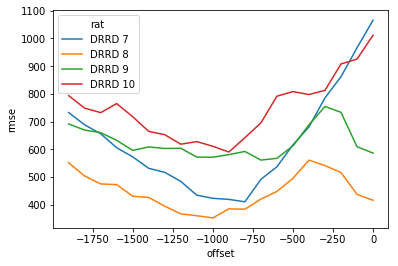

In [43]:
sns.lineplot(x='offset', y='rmse', hue='rat', data=gabi_df, markers='o')

## Striatum 

In [15]:
[onset_rmse('ELI 3', i*100, strpfc='PFC') for i in range(15)]

[1037.0228081848206,
 911.5367423487256,
 836.3657199788013,
 745.2227833613339,
 628.1477959730297,
 593.1249224257263,
 480.9894795862335,
 441.35790782572366,
 425.81050875270444,
 435.15349827063875,
 413.1853568867178,
 382.9065462891445,
 365.49322025596325,
 411.09325079187744,
 494.7163883337309]

In [132]:
[onset_rmse('ELI 3', i*100, strpfc='STR') for i in range(15)]

[1155.480309588896,
 1114.3648850716825,
 987.6193641244955,
 904.8564732833316,
 823.074005004205,
 744.3275868951721,
 651.6470554725747,
 562.7001837914453,
 517.5075601870228,
 439.90804588334674,
 388.18795785192094,
 393.0598872105594,
 367.6920866126053,
 413.6812736734807,
 418.6171039391211]

In [133]:
[onset_rmse('ELI 3_2', i*100, strpfc='PFC') for i in range(15)]

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[1181.537889461841,
 1073.1570371477533,
 965.3287322223651,
 875.7444645301349,
 772.5197586932353,
 675.8183589541046,
 580.818847720027,
 512.1268338363428,
 477.49885143666387,
 443.90554314190354,
 439.2160398954014,
 397.091820972405,
 381.06142921947907,
 370.2306600508923,
 402.99038499399006]

In [134]:
[onset_rmse('ELI 3_2', i*100, strpfc='STR') for i in range(15)]

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

[1197.1263521764715,
 1069.8259001228173,
 992.9574607894507,
 880.6704238772418,
 793.9029470653621,
 698.4603046864585,
 617.994887247836,
 517.3351703651895,
 450.45296534885,
 379.0297980301253,
 355.12895868059485,
 340.4231959462276,
 338.41187098454543,
 369.58252824420737,
 411.037567407887]

# Final analysis

In [16]:
%%time
eli_rats={}
for i, rat, area in product(range(20), SHORTCUTS['groups']['EZ'], ['STR', 'PFC']):
    %time eli_rats[(rat, i, area)] = onset_rmse(rat, i*100, False, area)

CPU times: user 1.98 s, sys: 15.2 ms, total: 2 s
Wall time: 1.99 s
CPU times: user 1.98 s, sys: 12.3 ms, total: 1.99 s
Wall time: 1.98 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 7.62 s, sys: 23.6 s, total: 31.3 s
Wall time: 2.99 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 10.1 s, sys: 34.8 s, total: 44.9 s
Wall time: 3.32 s
CPU times: user 1.87 s, sys: 2.42 s, total: 4.29 s
Wall time: 1.42 s
CPU times: user 1.32 s, sys: 7.81 ms, total: 1.33 s
Wall time: 1.32 s


KeyError: 'trial'

CPU times: user 2.24 s, sys: 3.14 ms, total: 2.24 s
Wall time: 2.24 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 7.6 s, sys: 20 s, total: 27.6 s
Wall time: 3.66 s
CPU times: user 7.05 s, sys: 18.2 s, total: 25.2 s
Wall time: 3.42 s
CPU times: user 2.91 s, sys: 3.07 s, total: 5.98 s
Wall time: 2.33 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 2.5 s, sys: 51.1 ms, total: 2.55 s
Wall time: 2.55 s
CPU times: user 1.71 s, sys: 22.2 ms, total: 1.73 s
Wall time: 1.72 s
CPU times: user 1.68 s, sys: 8.02 ms, total: 1.68 s
Wall time: 1.68 s
CPU times: user 1.88 s, sys: 17.9 ms, total: 1.9 s
Wall time: 1.89 s
CPU times: user 1.95 s, sys: 8.21 ms, total: 1.96 s
Wall time: 1.95 s
CPU times: user 2.07 s, sys: 10.6 ms, total: 2.08 s
Wall time: 2.08 s
CPU times: user 1.93 s, sys: 4.26 ms, total: 1.93 s
Wall time: 1.93 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 7.61 s, sys: 22.9 s, total: 30.5 s
Wall time: 3.03 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.15 s, sys: 30.2 s, total: 39.4 s
Wall time: 3.32 s
CPU times: user 1.93 s, sys: 2.97 s, total: 4.9 s
Wall time: 1.36 s
CPU times: user 1.28 s, sys: 12.9 ms, total: 1.29 s
Wall time: 1.29 s


KeyError: 'trial'

CPU times: user 2.08 s, sys: 7.21 ms, total: 2.09 s
Wall time: 2.08 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 7.64 s, sys: 19.8 s, total: 27.4 s
Wall time: 3.77 s
CPU times: user 6.78 s, sys: 17.2 s, total: 24 s
Wall time: 3.35 s
CPU times: user 2.78 s, sys: 3.13 s, total: 5.91 s
Wall time: 2.17 s
CPU times: user 2.39 s, sys: 29.1 ms, total: 2.42 s
Wall time: 2.42 s
CPU times: user 1.75 s, sys: 21.9 ms, total: 1.78 s
Wall time: 1.76 s
CPU times: user 1.75 s, sys: 10.8 ms, total: 1.76 s
Wall time: 1.76 s
CPU times: user 2.11 s, sys: 7.74 ms, total: 2.12 s
Wall time: 2.12 s
CPU times: user 2.12 s, sys: 5.96 ms, total: 2.13 s
Wall time: 2.12 s
CPU times: user 2.13 s, sys: 5.42 ms, total: 2.13 s
Wall time: 2.13 s
CPU times: user 2.05 s, sys: 20.4 ms, total: 2.07 s
Wall time: 2.06 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.98 s, sys: 34.4 s, total: 44.4 s
Wall time: 3.55 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.94 s, sys: 27.7 s, total: 36.6 s
Wall time: 3.31 s
CPU times: user 2.05 s, sys: 3 s, total: 5.05 s
Wall time: 1.48 s
CPU times: user 1.25 s, sys: 19.8 ms, total: 1.27 s
Wall time: 1.26 s


KeyError: 'trial'

CPU times: user 2.2 s, sys: 12.3 ms, total: 2.21 s
Wall time: 2.21 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 8.48 s, sys: 23.8 s, total: 32.3 s
Wall time: 3.85 s
CPU times: user 7.24 s, sys: 18.2 s, total: 25.4 s
Wall time: 3.5 s
CPU times: user 2.72 s, sys: 3 s, total: 5.72 s
Wall time: 2.19 s
CPU times: user 2.59 s, sys: 33.6 ms, total: 2.63 s
Wall time: 2.62 s
CPU times: user 1.7 s, sys: 12.8 ms, total: 1.71 s
Wall time: 1.71 s
CPU times: user 1.9 s, sys: 16.8 ms, total: 1.92 s
Wall time: 1.92 s
CPU times: user 2.06 s, sys: 26.2 ms, total: 2.08 s
Wall time: 2.06 s
CPU times: user 1.94 s, sys: 20.2 ms, total: 1.96 s
Wall time: 1.94 s
CPU times: user 1.97 s, sys: 13.4 ms, total: 1.99 s
Wall time: 1.98 s
CPU times: user 1.89 s, sys: 10.6 ms, total: 1.9 s
Wall time: 1.89 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 13.6 s, sys: 53.8 s, total: 1min 7s
Wall time: 4.11 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.34 s, sys: 30.1 s, total: 39.4 s
Wall time: 3.45 s
CPU times: user 2.03 s, sys: 2.98 s, total: 5.01 s
Wall time: 1.41 s
CPU times: user 1.48 s, sys: 15.3 ms, total: 1.5 s
Wall time: 1.49 s


KeyError: 'trial'

CPU times: user 2.07 s, sys: 4.07 ms, total: 2.07 s
Wall time: 2.07 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 11.4 s, sys: 36.8 s, total: 48.2 s
Wall time: 4.54 s
CPU times: user 6.64 s, sys: 16.2 s, total: 22.8 s
Wall time: 3.37 s
CPU times: user 2.52 s, sys: 2 s, total: 4.52 s
Wall time: 2.19 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 2.37 s, sys: 43.9 ms, total: 2.42 s
Wall time: 2.4 s
CPU times: user 1.77 s, sys: 14.2 ms, total: 1.79 s
Wall time: 1.78 s
CPU times: user 1.55 s, sys: 11 ms, total: 1.56 s
Wall time: 1.56 s
CPU times: user 1.97 s, sys: 15.5 ms, total: 1.98 s
Wall time: 1.97 s
CPU times: user 2 s, sys: 13.2 ms, total: 2.01 s
Wall time: 2 s
CPU times: user 1.93 s, sys: 4.59 ms, total: 1.93 s
Wall time: 1.93 s
CPU times: user 1.9 s, sys: 17.7 ms, total: 1.92 s
Wall time: 1.91 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.17 s, sys: 30.7 s, total: 39.8 s
Wall time: 3.18 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 11.8 s, sys: 43 s, total: 54.8 s
Wall time: 3.64 s
CPU times: user 1.8 s, sys: 2.5 s, total: 4.3 s
Wall time: 1.37 s
CPU times: user 1.36 s, sys: 9.92 ms, total: 1.37 s
Wall time: 1.36 s


KeyError: 'trial'

CPU times: user 2.42 s, sys: 12.4 ms, total: 2.43 s
Wall time: 2.43 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 7.48 s, sys: 20.4 s, total: 27.9 s
Wall time: 3.56 s
CPU times: user 7.2 s, sys: 19.4 s, total: 26.6 s
Wall time: 3.46 s
CPU times: user 2.86 s, sys: 3.16 s, total: 6.02 s
Wall time: 2.22 s
CPU times: user 2.35 s, sys: 41.9 ms, total: 2.39 s
Wall time: 2.38 s
CPU times: user 1.66 s, sys: 19.5 ms, total: 1.68 s
Wall time: 1.67 s
CPU times: user 1.64 s, sys: 23 ms, total: 1.67 s
Wall time: 1.65 s
CPU times: user 1.98 s, sys: 14.7 ms, total: 1.99 s
Wall time: 1.98 s
CPU times: user 1.89 s, sys: 13.2 ms, total: 1.9 s
Wall time: 1.9 s
CPU times: user 1.99 s, sys: 6.8 ms, total: 1.99 s
Wall time: 1.99 s
CPU times: user 1.9 s, sys: 9.23 ms, total: 1.91 s
Wall time: 1.9 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.86 s, sys: 29.9 s, total: 38.7 s
Wall time: 3.11 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 10.6 s, sys: 37.3 s, total: 48 s
Wall time: 3.46 s
CPU times: user 1.82 s, sys: 2.45 s, total: 4.27 s
Wall time: 1.39 s
CPU times: user 1.38 s, sys: 7.58 ms, total: 1.39 s
Wall time: 1.39 s


KeyError: 'trial'

CPU times: user 2.04 s, sys: 18.3 ms, total: 2.05 s
Wall time: 2.04 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 8.87 s, sys: 26.7 s, total: 35.6 s
Wall time: 3.89 s
CPU times: user 6.91 s, sys: 18 s, total: 24.9 s
Wall time: 3.48 s
CPU times: user 2.77 s, sys: 3.11 s, total: 5.88 s
Wall time: 2.2 s
CPU times: user 2.74 s, sys: 30.1 ms, total: 2.77 s
Wall time: 2.76 s
CPU times: user 1.75 s, sys: 8.42 ms, total: 1.76 s
Wall time: 1.76 s
CPU times: user 1.61 s, sys: 8.48 ms, total: 1.62 s
Wall time: 1.62 s
CPU times: user 2.04 s, sys: 6.32 ms, total: 2.05 s
Wall time: 2.04 s
CPU times: user 1.92 s, sys: 10.7 ms, total: 1.93 s
Wall time: 1.92 s
CPU times: user 1.97 s, sys: 11.5 ms, total: 1.98 s
Wall time: 1.97 s
CPU times: user 2.02 s, sys: 2.45 ms, total: 2.02 s
Wall time: 2.02 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 10.5 s, sys: 37.2 s, total: 47.7 s
Wall time: 3.59 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.91 s, sys: 32.8 s, total: 42.7 s
Wall time: 3.51 s
CPU times: user 2.07 s, sys: 2.91 s, total: 4.99 s
Wall time: 1.52 s
CPU times: user 1.48 s, sys: 5.35 ms, total: 1.48 s
Wall time: 1.48 s


KeyError: 'trial'

CPU times: user 2.15 s, sys: 2.1 ms, total: 2.16 s
Wall time: 2.16 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 11.7 s, sys: 38.2 s, total: 49.8 s
Wall time: 4.42 s
CPU times: user 7.67 s, sys: 20.2 s, total: 27.9 s
Wall time: 3.73 s
CPU times: user 3 s, sys: 3.05 s, total: 6.05 s
Wall time: 2.35 s
CPU times: user 2.62 s, sys: 37.4 ms, total: 2.66 s
Wall time: 2.66 s
CPU times: user 1.7 s, sys: 20.1 ms, total: 1.72 s
Wall time: 1.71 s
CPU times: user 1.69 s, sys: 10.4 ms, total: 1.7 s
Wall time: 1.69 s
CPU times: user 1.99 s, sys: 8.16 ms, total: 2 s
Wall time: 2 s
CPU times: user 1.91 s, sys: 16.2 ms, total: 1.93 s
Wall time: 1.92 s
CPU times: user 2.01 s, sys: 5.9 ms, total: 2.02 s
Wall time: 2.01 s
CPU times: user 1.9 s, sys: 21.7 ms, total: 1.92 s
Wall time: 1.9 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 7.62 s, sys: 22 s, total: 29.6 s
Wall time: 3.17 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.54 s, sys: 32.6 s, total: 42.1 s
Wall time: 3.22 s
CPU times: user 1.98 s, sys: 3.02 s, total: 5 s
Wall time: 1.41 s
CPU times: user 1.39 s, sys: 9.08 ms, total: 1.4 s
Wall time: 1.39 s


KeyError: 'trial'

CPU times: user 2.07 s, sys: 3.08 ms, total: 2.07 s
Wall time: 2.07 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 8.48 s, sys: 24.4 s, total: 32.9 s
Wall time: 3.78 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 6.62 s, sys: 16.2 s, total: 22.8 s
Wall time: 3.46 s
CPU times: user 2.74 s, sys: 3.09 s, total: 5.83 s
Wall time: 2.13 s
CPU times: user 2.61 s, sys: 51.7 ms, total: 2.66 s
Wall time: 2.64 s
CPU times: user 1.66 s, sys: 21.8 ms, total: 1.68 s
Wall time: 1.67 s
CPU times: user 1.59 s, sys: 16.3 ms, total: 1.61 s
Wall time: 1.6 s
CPU times: user 2.04 s, sys: 21.7 ms, total: 2.06 s
Wall time: 2.05 s
CPU times: user 1.94 s, sys: 10.4 ms, total: 1.95 s
Wall time: 1.94 s
CPU times: user 1.98 s, sys: 10.6 ms, total: 1.99 s
Wall time: 1.98 s
CPU times: user 1.92 s, sys: 3.89 ms, total: 1.93 s
Wall time: 1.92 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 7.77 s, sys: 23.9 s, total: 31.6 s
Wall time: 3.08 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.15 s, sys: 25.1 s, total: 33.2 s
Wall time: 3.35 s
CPU times: user 2.05 s, sys: 2.9 s, total: 4.96 s
Wall time: 1.46 s
CPU times: user 1.32 s, sys: 11.8 ms, total: 1.33 s
Wall time: 1.33 s


KeyError: 'trial'

CPU times: user 2.11 s, sys: 7.98 ms, total: 2.11 s
Wall time: 2.11 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 7.55 s, sys: 18.4 s, total: 25.9 s
Wall time: 3.73 s
CPU times: user 7.05 s, sys: 17 s, total: 24.1 s
Wall time: 3.66 s
CPU times: user 2.77 s, sys: 3.17 s, total: 5.94 s
Wall time: 2.21 s
CPU times: user 2.44 s, sys: 46.3 ms, total: 2.49 s
Wall time: 2.46 s
CPU times: user 1.73 s, sys: 17.3 ms, total: 1.75 s
Wall time: 1.74 s
CPU times: user 1.83 s, sys: 8.8 ms, total: 1.84 s
Wall time: 1.83 s
CPU times: user 2.24 s, sys: 13.5 ms, total: 2.25 s
Wall time: 2.25 s
CPU times: user 2.1 s, sys: 17.3 ms, total: 2.11 s
Wall time: 2.1 s
CPU times: user 2.19 s, sys: 6.36 ms, total: 2.2 s
Wall time: 2.2 s
CPU times: user 2 s, sys: 9.25 ms, total: 2.01 s
Wall time: 2 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.2 s, sys: 25.6 s, total: 33.8 s
Wall time: 3.22 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.05 s, sys: 25.2 s, total: 33.3 s
Wall time: 2.99 s
CPU times: user 2.03 s, sys: 3.08 s, total: 5.11 s
Wall time: 1.4 s
CPU times: user 1.37 s, sys: 5.98 ms, total: 1.37 s
Wall time: 1.37 s


KeyError: 'trial'

CPU times: user 2.02 s, sys: 3.44 ms, total: 2.03 s
Wall time: 2.03 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 8.35 s, sys: 23.4 s, total: 31.8 s
Wall time: 3.9 s
CPU times: user 7.12 s, sys: 18.9 s, total: 26 s
Wall time: 3.53 s
CPU times: user 2.6 s, sys: 2.35 s, total: 4.95 s
Wall time: 2.19 s
CPU times: user 2.4 s, sys: 36.2 ms, total: 2.43 s
Wall time: 2.41 s
CPU times: user 1.77 s, sys: 4.61 ms, total: 1.77 s
Wall time: 1.77 s
CPU times: user 1.57 s, sys: 4.2 ms, total: 1.58 s
Wall time: 1.57 s
CPU times: user 2 s, sys: 17.7 ms, total: 2.02 s
Wall time: 2.01 s
CPU times: user 2.01 s, sys: 15.5 ms, total: 2.03 s
Wall time: 2.02 s
CPU times: user 1.91 s, sys: 4.1 ms, total: 1.91 s
Wall time: 1.91 s
CPU times: user 1.91 s, sys: 18.3 ms, total: 1.93 s
Wall time: 1.91 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 7.61 s, sys: 23.2 s, total: 30.8 s
Wall time: 3.01 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.88 s, sys: 33.8 s, total: 43.7 s
Wall time: 3.44 s
CPU times: user 2.06 s, sys: 3.1 s, total: 5.17 s
Wall time: 1.48 s
CPU times: user 1.36 s, sys: 6.1 ms, total: 1.36 s
Wall time: 1.36 s


KeyError: 'trial'

CPU times: user 2.36 s, sys: 5.68 ms, total: 2.36 s
Wall time: 2.36 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 7.39 s, sys: 17.3 s, total: 24.7 s
Wall time: 3.74 s
CPU times: user 8.84 s, sys: 26 s, total: 34.8 s
Wall time: 3.93 s
CPU times: user 2.83 s, sys: 3.17 s, total: 6 s
Wall time: 2.21 s
CPU times: user 2.42 s, sys: 34.3 ms, total: 2.46 s
Wall time: 2.45 s
CPU times: user 1.65 s, sys: 12.4 ms, total: 1.66 s
Wall time: 1.66 s
CPU times: user 1.59 s, sys: 17.9 ms, total: 1.6 s
Wall time: 1.59 s
CPU times: user 2.03 s, sys: 9.04 ms, total: 2.04 s
Wall time: 2.03 s
CPU times: user 1.91 s, sys: 5.62 ms, total: 1.92 s
Wall time: 1.92 s
CPU times: user 1.93 s, sys: 7.89 ms, total: 1.94 s
Wall time: 1.93 s
CPU times: user 1.93 s, sys: 21.8 ms, total: 1.95 s
Wall time: 1.94 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 7.5 s, sys: 22.2 s, total: 29.7 s
Wall time: 2.97 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.09 s, sys: 29.6 s, total: 38.7 s
Wall time: 3.19 s
CPU times: user 1.97 s, sys: 3.1 s, total: 5.07 s
Wall time: 1.36 s
CPU times: user 1.3 s, sys: 21.3 ms, total: 1.33 s
Wall time: 1.31 s


KeyError: 'trial'

CPU times: user 2.08 s, sys: 12.7 ms, total: 2.09 s
Wall time: 2.08 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 9.12 s, sys: 26.5 s, total: 35.7 s
Wall time: 3.96 s
CPU times: user 6.76 s, sys: 16.5 s, total: 23.3 s
Wall time: 3.49 s
CPU times: user 2.81 s, sys: 3.23 s, total: 6.04 s
Wall time: 2.22 s
CPU times: user 2.6 s, sys: 30 ms, total: 2.63 s
Wall time: 2.63 s
CPU times: user 1.95 s, sys: 11.1 ms, total: 1.97 s
Wall time: 1.96 s
CPU times: user 1.6 s, sys: 6.61 ms, total: 1.61 s
Wall time: 1.61 s
CPU times: user 2 s, sys: 14.7 ms, total: 2.01 s
Wall time: 2 s
CPU times: user 2.02 s, sys: 11.8 ms, total: 2.03 s
Wall time: 2.03 s
CPU times: user 1.91 s, sys: 3.29 ms, total: 1.91 s
Wall time: 1.91 s
CPU times: user 1.88 s, sys: 11.3 ms, total: 1.89 s
Wall time: 1.88 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.55 s, sys: 26.7 s, total: 35.2 s
Wall time: 3.23 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.75 s, sys: 33.5 s, total: 43.3 s
Wall time: 3.53 s
CPU times: user 2.06 s, sys: 3.01 s, total: 5.07 s
Wall time: 1.47 s
CPU times: user 1.27 s, sys: 10.7 ms, total: 1.29 s
Wall time: 1.28 s


KeyError: 'trial'

CPU times: user 2.31 s, sys: 4.16 ms, total: 2.31 s
Wall time: 2.31 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 7.49 s, sys: 19.4 s, total: 26.9 s
Wall time: 3.62 s
CPU times: user 6.59 s, sys: 16.1 s, total: 22.7 s
Wall time: 3.33 s
CPU times: user 2.78 s, sys: 3.24 s, total: 6.02 s
Wall time: 2.22 s
CPU times: user 2.4 s, sys: 36.1 ms, total: 2.43 s
Wall time: 2.42 s
CPU times: user 1.76 s, sys: 9.15 ms, total: 1.77 s
Wall time: 1.77 s
CPU times: user 1.63 s, sys: 7.85 ms, total: 1.63 s
Wall time: 1.63 s
CPU times: user 1.92 s, sys: 8.82 ms, total: 1.93 s
Wall time: 1.93 s
CPU times: user 1.98 s, sys: 17.7 ms, total: 2 s
Wall time: 1.99 s
CPU times: user 2.01 s, sys: 11.3 ms, total: 2.02 s
Wall time: 2.01 s
CPU times: user 1.87 s, sys: 24 ms, total: 1.89 s
Wall time: 1.88 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.4 s, sys: 26.4 s, total: 34.8 s
Wall time: 3.39 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 10.5 s, sys: 36.9 s, total: 47.4 s
Wall time: 3.39 s
CPU times: user 1.95 s, sys: 2.84 s, total: 4.79 s
Wall time: 1.46 s
CPU times: user 1.27 s, sys: 8.42 ms, total: 1.28 s
Wall time: 1.28 s


KeyError: 'trial'

CPU times: user 2.06 s, sys: 3.49 ms, total: 2.07 s
Wall time: 2.06 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 7.58 s, sys: 19.8 s, total: 27.4 s
Wall time: 3.62 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 7.16 s, sys: 18.5 s, total: 25.7 s
Wall time: 3.46 s
CPU times: user 2.58 s, sys: 2.37 s, total: 4.95 s
Wall time: 2.12 s
CPU times: user 2.32 s, sys: 22.5 ms, total: 2.34 s
Wall time: 2.34 s
CPU times: user 1.8 s, sys: 9.64 ms, total: 1.81 s
Wall time: 1.81 s
CPU times: user 1.55 s, sys: 5.45 ms, total: 1.55 s
Wall time: 1.55 s
CPU times: user 1.93 s, sys: 8.47 ms, total: 1.94 s
Wall time: 1.94 s
CPU times: user 2.03 s, sys: 4.88 ms, total: 2.03 s
Wall time: 2.03 s
CPU times: user 1.89 s, sys: 7.3 ms, total: 1.9 s
Wall time: 1.9 s
CPU times: user 1.91 s, sys: 6.57 ms, total: 1.91 s
Wall time: 1.91 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 9.82 s, sys: 34 s, total: 43.8 s
Wall time: 3.27 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.6 s, sys: 28.9 s, total: 37.5 s
Wall time: 3.18 s
CPU times: user 2.07 s, sys: 3.1 s, total: 5.16 s
Wall time: 1.44 s
CPU times: user 1.27 s, sys: 15.1 ms, total: 1.28 s
Wall time: 1.27 s


KeyError: 'trial'

CPU times: user 2.06 s, sys: 5.93 ms, total: 2.07 s
Wall time: 2.06 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 8.72 s, sys: 24.5 s, total: 33.2 s
Wall time: 3.75 s
CPU times: user 7.41 s, sys: 19 s, total: 26.4 s
Wall time: 3.49 s
CPU times: user 2.81 s, sys: 3.21 s, total: 6.03 s
Wall time: 2.17 s
CPU times: user 2.38 s, sys: 51.2 ms, total: 2.44 s
Wall time: 2.41 s
CPU times: user 1.72 s, sys: 11.1 ms, total: 1.74 s
Wall time: 1.73 s
CPU times: user 1.58 s, sys: 9.47 ms, total: 1.59 s
Wall time: 1.58 s
CPU times: user 2.01 s, sys: 13.4 ms, total: 2.02 s
Wall time: 2.01 s
CPU times: user 1.93 s, sys: 5.96 ms, total: 1.94 s
Wall time: 1.94 s
CPU times: user 1.96 s, sys: 7.43 ms, total: 1.97 s
Wall time: 1.96 s
CPU times: user 1.94 s, sys: 14.3 ms, total: 1.96 s
Wall time: 1.95 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.63 s, sys: 28.2 s, total: 36.8 s
Wall time: 3.24 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 10.4 s, sys: 35.1 s, total: 45.4 s
Wall time: 3.48 s
CPU times: user 2.1 s, sys: 3.06 s, total: 5.16 s
Wall time: 1.48 s
CPU times: user 1.59 s, sys: 10.4 ms, total: 1.6 s
Wall time: 1.6 s


KeyError: 'trial'

CPU times: user 2.04 s, sys: 7.85 ms, total: 2.05 s
Wall time: 2.05 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 7.85 s, sys: 20.8 s, total: 28.7 s
Wall time: 3.81 s
CPU times: user 7.02 s, sys: 18.1 s, total: 25.1 s
Wall time: 3.44 s
CPU times: user 2.86 s, sys: 3.23 s, total: 6.08 s
Wall time: 2.22 s
CPU times: user 2.36 s, sys: 39 ms, total: 2.4 s
Wall time: 2.39 s
CPU times: user 1.68 s, sys: 22.2 ms, total: 1.7 s
Wall time: 1.69 s
CPU times: user 1.92 s, sys: 14.5 ms, total: 1.94 s
Wall time: 1.93 s
CPU times: user 2.11 s, sys: 3.69 ms, total: 2.11 s
Wall time: 2.11 s
CPU times: user 2.09 s, sys: 7.16 ms, total: 2.09 s
Wall time: 2.09 s
CPU times: user 1.89 s, sys: 9.41 ms, total: 1.9 s
Wall time: 1.89 s
CPU times: user 2.15 s, sys: 8.76 ms, total: 2.16 s
Wall time: 2.16 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.65 s, sys: 28.6 s, total: 37.2 s
Wall time: 3.15 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.85 s, sys: 28 s, total: 36.9 s
Wall time: 3.29 s
CPU times: user 1.99 s, sys: 3.04 s, total: 5.03 s
Wall time: 1.36 s
CPU times: user 1.34 s, sys: 5.9 ms, total: 1.35 s
Wall time: 1.35 s


KeyError: 'trial'

CPU times: user 2.26 s, sys: 11.3 ms, total: 2.27 s
Wall time: 2.27 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 3.34 s, sys: 74.7 ms, total: 3.41 s
Wall time: 3.39 s
CPU times: user 3.1 s, sys: 60.3 ms, total: 3.16 s
Wall time: 3.13 s
CPU times: user 2.21 s, sys: 19.8 ms, total: 2.23 s
Wall time: 2.23 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 2.65 s, sys: 36.3 ms, total: 2.69 s
Wall time: 2.69 s
CPU times: user 1.88 s, sys: 7.29 ms, total: 1.89 s
Wall time: 1.89 s
CPU times: user 1.75 s, sys: 8.33 ms, total: 1.76 s
Wall time: 1.76 s
CPU times: user 2.05 s, sys: 15.1 ms, total: 2.06 s
Wall time: 2.06 s
CPU times: user 2.09 s, sys: 10 ms, total: 2.1 s
Wall time: 2.09 s
CPU times: user 2.08 s, sys: 10.4 ms, total: 2.09 s
Wall time: 2.09 s
CPU times: user 2.04 s, sys: 13.1 ms, total: 2.05 s
Wall time: 2.04 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 7.99 s, sys: 24.9 s, total: 32.9 s
Wall time: 3.14 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.66 s, sys: 26.8 s, total: 35.4 s
Wall time: 3.31 s
CPU times: user 1.95 s, sys: 3.13 s, total: 5.09 s
Wall time: 1.41 s
CPU times: user 1.38 s, sys: 12.1 ms, total: 1.4 s
Wall time: 1.4 s


KeyError: 'trial'

CPU times: user 2.24 s, sys: 9.72 ms, total: 2.25 s
Wall time: 2.24 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 3.48 s, sys: 70.7 ms, total: 3.55 s
Wall time: 3.53 s
CPU times: user 3.23 s, sys: 46 ms, total: 3.27 s
Wall time: 3.27 s
CPU times: user 2.37 s, sys: 21.1 ms, total: 2.39 s
Wall time: 2.39 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 2.54 s, sys: 45.1 ms, total: 2.59 s
Wall time: 2.58 s
CPU times: user 1.71 s, sys: 8.66 ms, total: 1.72 s
Wall time: 1.72 s
CPU times: user 1.67 s, sys: 8.85 ms, total: 1.68 s
Wall time: 1.67 s
CPU times: user 1.98 s, sys: 9.87 ms, total: 1.99 s
Wall time: 1.98 s
CPU times: user 1.96 s, sys: 11 ms, total: 1.97 s
Wall time: 1.96 s
CPU times: user 2.04 s, sys: 11.4 ms, total: 2.05 s
Wall time: 2.04 s
CPU times: user 1.87 s, sys: 13.1 ms, total: 1.89 s
Wall time: 1.88 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 7.1 s, sys: 21.3 s, total: 28.4 s
Wall time: 2.95 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 8.11 s, sys: 25.7 s, total: 33.8 s
Wall time: 3.01 s
CPU times: user 1.96 s, sys: 3.16 s, total: 5.12 s
Wall time: 1.36 s
CPU times: user 1.39 s, sys: 5.79 ms, total: 1.39 s
Wall time: 1.39 s


KeyError: 'trial'

CPU times: user 2.03 s, sys: 3.91 ms, total: 2.04 s
Wall time: 2.03 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 3.36 s, sys: 58.5 ms, total: 3.41 s
Wall time: 3.41 s
CPU times: user 3.06 s, sys: 36.8 ms, total: 3.1 s
Wall time: 3.1 s
CPU times: user 2.16 s, sys: 9.54 ms, total: 2.17 s
Wall time: 2.16 s
CPU times: user 2.4 s, sys: 32.2 ms, total: 2.43 s
Wall time: 2.43 s
CPU times: user 1.74 s, sys: 7.39 ms, total: 1.75 s
Wall time: 1.75 s
CPU times: user 1.84 s, sys: 12.5 ms, total: 1.86 s
Wall time: 1.85 s
CPU times: user 2.08 s, sys: 10.7 ms, total: 2.09 s
Wall time: 2.08 s
CPU times: user 2.16 s, sys: 11.1 ms, total: 2.17 s
Wall time: 2.16 s
CPU times: user 2.11 s, sys: 9.27 ms, total: 2.12 s
Wall time: 2.12 s
CPU times: user 2.07 s, sys: 13.7 ms, total: 2.09 s
Wall time: 2.08 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 13.1 s, sys: 49.3 s, total: 1min 2s
Wall time: 4.22 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 10.3 s, sys: 35.8 s, total: 46.1 s
Wall time: 3.68 s
CPU times: user 2.1 s, sys: 2.91 s, total: 5.01 s
Wall time: 1.5 s
CPU times: user 1.38 s, sys: 6.14 ms, total: 1.39 s
Wall time: 1.39 s


KeyError: 'trial'

CPU times: user 2.18 s, sys: 3.06 ms, total: 2.18 s
Wall time: 2.18 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic

CPU times: user 3.45 s, sys: 52.1 ms, total: 3.5 s
Wall time: 3.5 s
CPU times: user 3.37 s, sys: 62.4 ms, total: 3.43 s
Wall time: 3.41 s
CPU times: user 2.22 s, sys: 20.7 ms, total: 2.24 s
Wall time: 2.23 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 2.51 s, sys: 43.2 ms, total: 2.55 s
Wall time: 2.54 s
CPU times: user 1.79 s, sys: 8.57 ms, total: 1.8 s
Wall time: 1.8 s
CPU times: user 1.89 s, sys: 18.8 ms, total: 1.91 s
Wall time: 1.9 s
CPU times: user 2.12 s, sys: 17 ms, total: 2.14 s
Wall time: 2.13 s
CPU times: user 2.05 s, sys: 14.6 ms, total: 2.06 s
Wall time: 2.05 s
CPU times: user 18min 10s, sys: 33min 29s, total: 51min 39s
Wall time: 11min 43s


In [17]:
eli_df = pd.DataFrame(eli_rats, index=['rmse']).T.reset_index()
eli_df.columns = ['rat', 'offset', 'area', 'rmse']
eli_df['offset'] = eli_df['offset']*(-100)
eli_df.head()

,rat,offset,area,rmse
0,ELI 3,0,STR,1070.896992
1,ELI 3,0,PFC,1019.542751
2,ELI 4,0,STR,1289.924850
3,ELI 4,0,PFC,1292.448478
4,ELI 5,0,STR,1014.260545


In [18]:
eli_df['day'] = eli_df.rat.str.contains('_2').astype(int)+1
eli_df.loc[eli_df['day']==2, 'rat'] = eli_df['rat'].apply(lambda s: s[:-2])

In [19]:
eli_df.head()

,rat,offset,area,rmse,day
0,ELI 3,0,STR,1070.896992,1
1,ELI 3,0,PFC,1019.542751,1
2,ELI 4,0,STR,1289.924850,1
3,ELI 4,0,PFC,1292.448478,1
4,ELI 5,0,STR,1014.260545,1


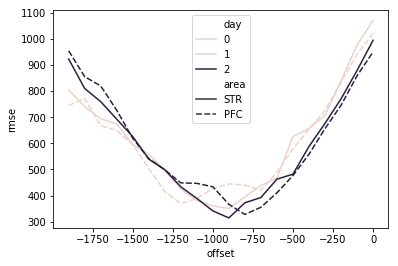

In [35]:
sns.lineplot(x='offset', y='rmse', hue='day', style='area', data=eli_df[eli_df.rat=='ELI 3'])

In [31]:
eli_df[eli_df.rat=='ELI 4']

,rat,offset,area,rmse,day
4,ELI 4,0,PFC,1778.380841,2
12,ELI 4,-100,PFC,1698.457807,2
20,ELI 4,-200,PFC,1554.255223,2
28,ELI 4,-300,PFC,1457.289574,2
36,ELI 4,-400,PFC,1343.569315,2
44,ELI 4,-500,PFC,1298.332573,2
52,ELI 4,-600,PFC,1225.686509,2
60,ELI 4,-700,PFC,1150.550759,2
68,ELI 4,-800,PFC,1056.498948,2
76,ELI 4,-900,PFC,939.502435,2


In [56]:
select(io.load('ELI 5_2', 'wide_smoothed'), _min_quality=0).reset_index().drop_duplicates('unit').area.value_counts()

STR    17
PFC     5
Name: area, dtype: int64

In [42]:
eli_df

,rat,offset,area,rmse,day
0,ELI 3,0,STR,1439.413442,1
1,ELI 3,0,PFC,1413.261345,1
2,ELI 5,0,STR,1404.761925,1
3,ELI 6,0,PFC,1559.179838,1
4,ELI 4,0,PFC,1778.380841,2
5,ELI 5,0,STR,1351.352071,2
6,ELI 5,0,PFC,1339.161321,2
7,ELI 6,0,STR,1193.079546,2
8,ELI 3,-100,STR,1313.966880,1
9,ELI 3,-100,PFC,1328.255877,1


# Old

## Testing

In [75]:
rat = select(io.load('DRRD 8', 'wide_smoothed'), _min_duration=1.5, is_selected=True, is_tired=False)
X, y, t, time = to_response_df(rat, 200, True, 300)

### Cross predicting 

In [79]:
res = cross_val_predict(pipe, X, y, t, cv=10)
res = pd.DataFrame(np.stack((t, y, res, time)).T)
res.columns=['trial', 'true', 'pred', 'time']

### Cross validating metrics

In [82]:
mean_predicted_onset = res[res.pred.astype(bool)].groupby('trial')['time'].mean()
mean_true_onset = res[res.true.astype(bool)].groupby('trial')['time'].mean()

In [83]:
np.sqrt((mean_true_onset - mean_predicted_onset).dropna()**2).mean()

575.2128518503328

In [ ]:
pipe = make_pipeline(RobustScaler(),
                         RandomUnderSampler(),
                         LogisticRegression(solver='lbfgs'))

scoring=['roc_auc', 'precision', 'recall', 'accuracy', 'f1']
res = pd.DataFrame(cross_validate(pipe, X, y, t, scoring, GroupKFold(10), return_train_score=True))
res.mean()

In [12]:
pipe = make_pipeline(RobustScaler(),
                         LogisticRegression(solver='lbfgs'))

scoring=['roc_auc', 'precision', 'recall', 'accuracy', 'f1']
res = pd.DataFrame(cross_validate(pipe, X, y, t, scoring, 10, return_train_score=True))
res

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy,test_f1,train_f1
0,0.120475,0.009295,0.898936,0.898220,0.635135,0.726244,0.505376,0.386282,0.911515,0.914914,0.562874,0.504321
1,0.103257,0.008828,0.896116,0.899148,0.762712,0.713318,0.483871,0.380265,0.924848,0.913430,0.592105,0.496075
2,0.099069,0.008767,0.908632,0.899035,0.718750,0.729258,0.247312,0.401925,0.904242,0.916262,0.368000,0.518231
3,0.084529,0.007577,0.862991,0.902381,0.500000,0.747788,0.268817,0.406739,0.887273,0.918150,0.349650,0.526890
4,0.079583,0.005551,0.931234,0.895155,0.745098,0.719178,0.413043,0.378606,0.918689,0.913712,0.531469,0.496063
5,0.073768,0.007553,0.890027,0.898927,0.680000,0.739819,0.369565,0.393029,0.910194,0.916408,0.478873,0.513344
6,0.089525,0.007745,0.876975,0.899600,0.702703,0.723684,0.282609,0.396635,0.906553,0.915330,0.403101,0.512422
7,0.092046,0.007651,0.888286,0.899348,0.735849,0.718121,0.423913,0.385817,0.918591,0.914128,0.537931,0.501955
8,0.099251,0.007529,0.874695,0.900708,0.719298,0.719027,0.445652,0.390625,0.918591,0.914532,0.550336,0.506231
9,0.084130,0.007535,0.862532,0.901745,0.780488,0.720982,0.347826,0.388221,0.916160,0.914532,0.481203,0.504688
